In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

%pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
%pip install -q captum

%matplotlib inline
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GraphConv, global_add_pool

import torch
from torch.nn import Linear
import torch.nn.functional as F

import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx
import random
from captum.attr import Saliency, IntegratedGradients
from collections import defaultdict


2.3.1+cu121
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/home/elston/anaconda3/lib/python3.12/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [2]:
path = '.'
dataset = TUDataset(path, name='Mutagenicity').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

Processing...
Done!


In [3]:
def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

# Visualizing a random molecule

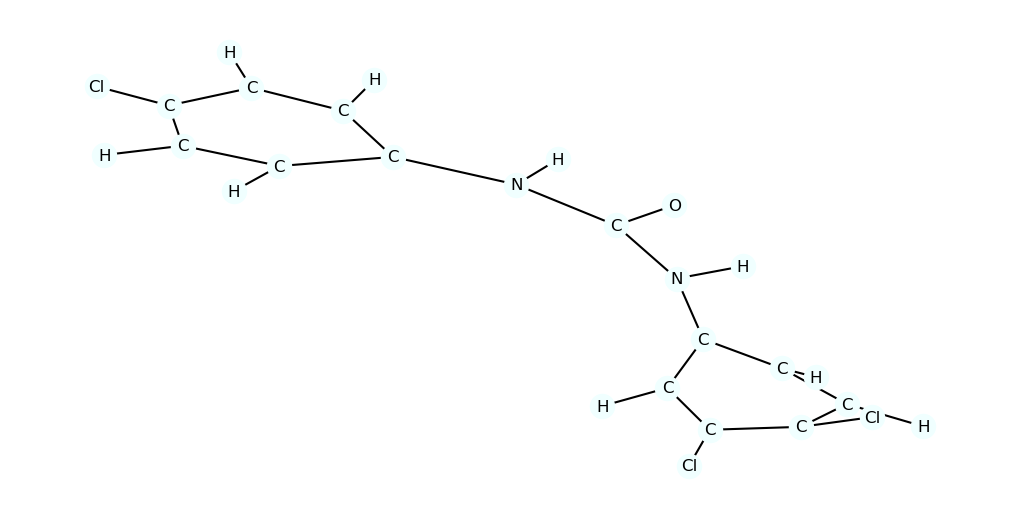

In [4]:
data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [5]:
class GNN(torch.nn.Module):
    def __init__(self, dim):
        super(GNN, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.fc1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


In [6]:
def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

train_acc_all = []
test_acc_all = []
epochs = 200

for epoch in range(epochs+1):
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    loss = loss_all / len(train_dataset)

    if epoch == 100:
      for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_all.append(train_acc)
    test_acc_all.append(test_acc)
    if not epoch % 10:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')


Epoch: 000, Loss: 0.8083, Train: 0.6457, Test: 0.6767
Epoch: 010, Loss: 0.5116, Train: 0.7592, Test: 0.7598
Epoch: 020, Loss: 0.4519, Train: 0.7902, Test: 0.7991
Epoch: 030, Loss: 0.4166, Train: 0.8169, Test: 0.7945
Epoch: 040, Loss: 0.4009, Train: 0.8202, Test: 0.7921
Epoch: 050, Loss: 0.3753, Train: 0.8381, Test: 0.8014
Epoch: 060, Loss: 0.3417, Train: 0.8619, Test: 0.8129
Epoch: 070, Loss: 0.3332, Train: 0.8648, Test: 0.8014
Epoch: 080, Loss: 0.3075, Train: 0.8747, Test: 0.8083
Epoch: 090, Loss: 0.2966, Train: 0.8768, Test: 0.8222
Epoch: 100, Loss: 0.2795, Train: 0.8845, Test: 0.8268
Epoch: 110, Loss: 0.2908, Train: 0.8635, Test: 0.8199
Epoch: 120, Loss: 0.2855, Train: 0.8737, Test: 0.8222
Epoch: 130, Loss: 0.2671, Train: 0.8804, Test: 0.8268
Epoch: 140, Loss: 0.2600, Train: 0.8896, Test: 0.8337
Epoch: 150, Loss: 0.2537, Train: 0.8904, Test: 0.8314
Epoch: 160, Loss: 0.2439, Train: 0.8970, Test: 0.8314
Epoch: 170, Loss: 0.2378, Train: 0.9014, Test: 0.8383
Epoch: 180, Loss: 0.2318, Tr

In [8]:
def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

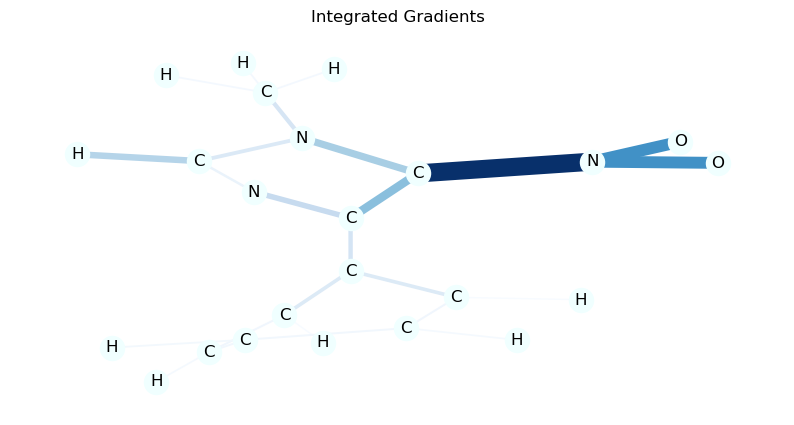

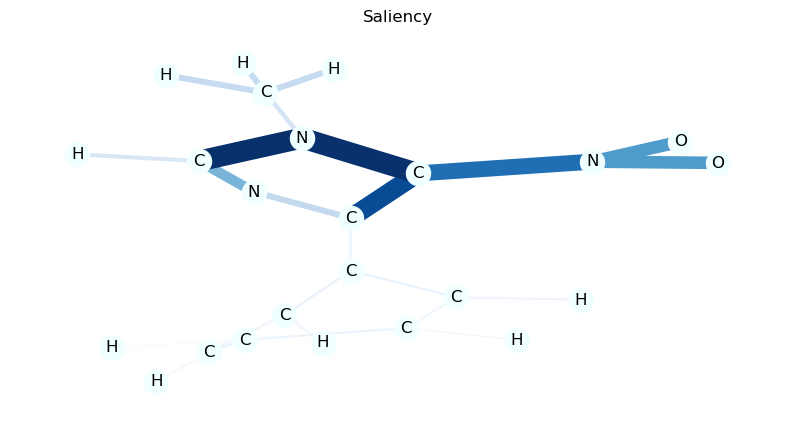

In [13]:
data = random.choice([t for t in test_dataset if not t.y.item()])
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

### Observations
- NO2 substructure highlighted which makes molecules mutagenic in many cases
- Amide groups (`C=O` and `C-N` bonds)
- Saliency method noisier so some link between `C-H` bonds may be wrong since they are not as reactive
- `N-N` and `N-C` are valid as nitrogen functionalities are often involved in biological activity and mutagenicity (e.g., nitrosamines, azo groups)

# Proteins dataset

In [14]:
path = '.'
dataset = TUDataset(path, name='AIDS').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32)

Processing...
Done!


In [15]:
data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
labels = [data.y.item() for data in dataset]
unique_labels = torch.unique(torch.tensor(labels))
print(f"Classes: {unique_labels.tolist()}")

Dataset: AIDS(2000):
Number of graphs: 2000
Number of features: 38
Number of classes: 2
Number of nodes: 11
Number of edges: 22
Average node degree: 2.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Classes: [0, 1]


In [16]:
def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'N', 'Cl', 'F', 'S', 'Se', 'P', 'Na', 'I', 'Co', 'Br', 'Li', 'Si', 'Mg', 'Cu', 'As', 'B',
                'Pt', 'Ru', 'K', 'Pd', 'Au', 'Te', 'W', 'Rh', 'Zn', 'Bi', 'Pb', 'Ge', 'Sb', 'Sn', 'Ga', 'Hg', 'Ho', 'Tl',
                'Ni', 'Tb']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

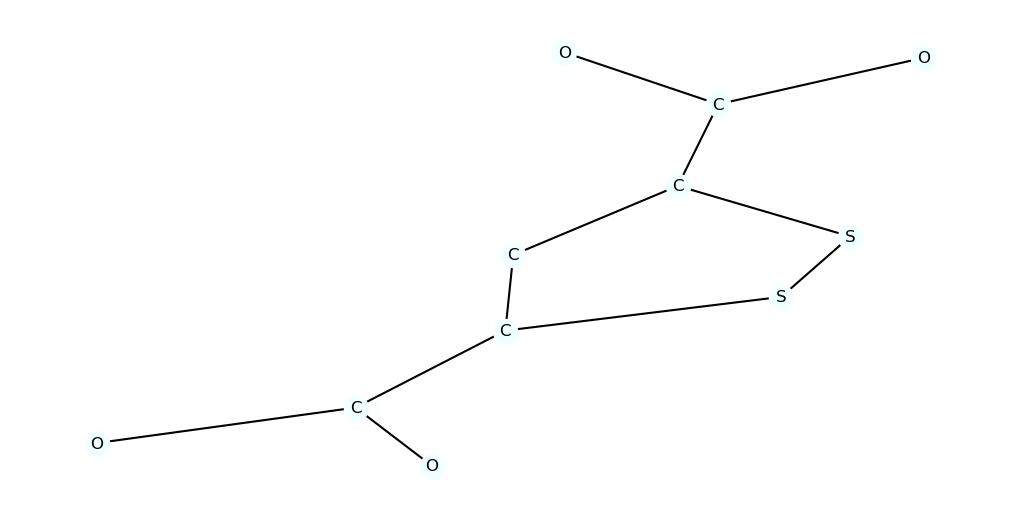

In [18]:
data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [19]:
class GNN(torch.nn.Module):
    def __init__(self, dim):
        super(GNN, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.fc1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

train_acc_all = []
test_acc_all = []
epochs = 80

for epoch in range(epochs+1):
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    loss = loss_all / len(train_dataset)

    if epoch == 100:
      for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_all.append(train_acc)
    test_acc_all.append(test_acc)
    if not epoch % 10:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')


Epoch: 000, Loss: 0.6618, Train: 0.7933, Test: 0.8350
Epoch: 010, Loss: 0.1802, Train: 0.9594, Test: 0.9650
Epoch: 020, Loss: 0.0813, Train: 0.9600, Test: 0.9650
Epoch: 030, Loss: 0.0477, Train: 0.9750, Test: 0.9750
Epoch: 040, Loss: 0.0398, Train: 0.9967, Test: 0.9900
Epoch: 050, Loss: 0.0195, Train: 0.9978, Test: 0.9850
Epoch: 060, Loss: 0.0128, Train: 0.9989, Test: 0.9850
Epoch: 070, Loss: 0.0106, Train: 0.9989, Test: 0.9900
Epoch: 080, Loss: 0.0185, Train: 0.9972, Test: 0.9850


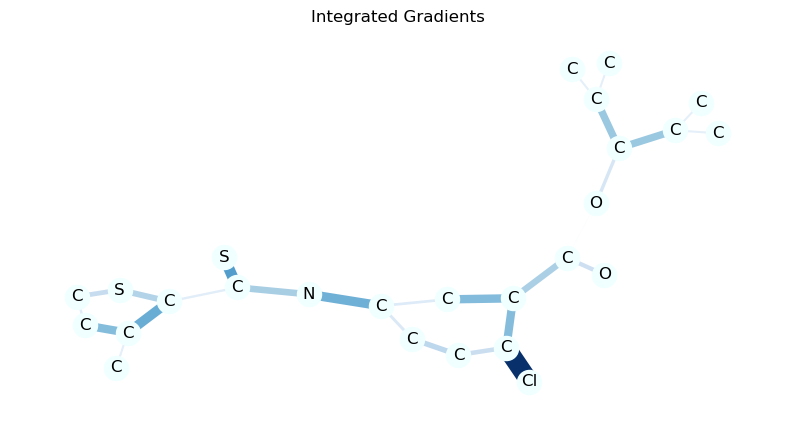

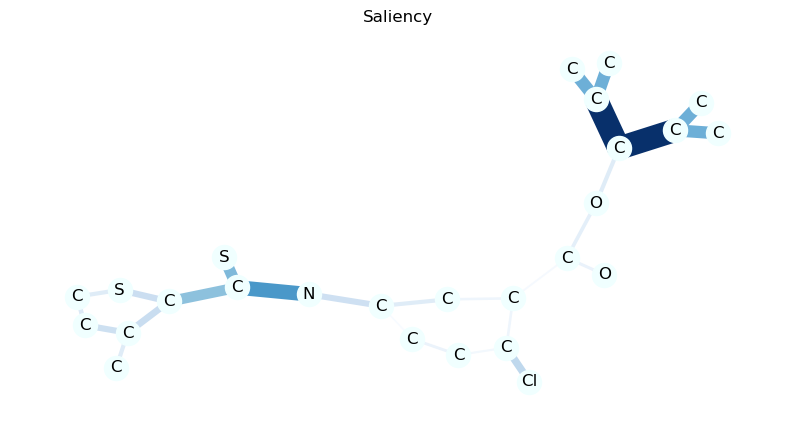

In [34]:
data = random.choice([t for t in test_dataset if not t.y.item()])
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

The integrated gradients visualisation highlights a chlorinated sidechain and halogens like Cl often impact bioactivity and chlorinated hydrocarbons are common in HIV inhibitors

The saliency map also highlights amide groups which are also common in HIV inhibitors